# Preprocessing crowd feasibility data

Here, we combine our two batches of crowdsourcing results and, for reasons of extra caution, we remove the following data about the study contributors from further analysis:
- year of birth (column `year_of_birth`), which is replaced by a coarser `age_group` field;
- location (column `nation`) 

In [1]:
%run ../notebook_preamble_Transitions.ipy
import mapping_career_causeways.plotting_utils as plotting_utils

# Crowd feasibility ratings
path_to_val_data_1 = data_folder + 'restricted/validation/nesta_output_16Dec.csv'
path_to_val_data_2 = data_folder + 'restricted/validation/nesta_output_4_Jan_2021.csv'
batch_results = pd.concat([pd.read_csv(path_to_val_data_1), pd.read_csv(path_to_val_data_2)], axis=0)

In [2]:
# Location for exporting the processed data
outputs_folder = f'{data_folder}processed/validation/'
figure_folder = useful_paths.codebase_dir + 'reports/crowd_feasibility_ratings/figures/'

# Set up font sizes
SMALL_SIZE = 13
MEDIUM_SIZE=14
plt.rc('font', size=SMALL_SIZE, family='Arial')
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)

# 1. Summary statistics of the removed fields

Produce summary descriptions about the contributors' year of birth and location, before removing these descriptors from the data.

In [3]:
# Full dataframe of the crowdsourced feasibility ratings
batch_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70359 entries, 0 to 32024
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   classification_id                 70359 non-null  int64 
 1   subject_ids                       70359 non-null  int64 
 2   origin_id                         70359 non-null  int64 
 3   origin_label                      70359 non-null  object
 4   origin_description                70359 non-null  object
 5   destination_id                    70359 non-null  int64 
 6   destination_label                 70359 non-null  object
 7   destination_description           70359 non-null  object
 8   perfectly_matched_skills          59402 non-null  object
 9   partially_matched_skills          53095 non-null  object
 10  unmatched_skills                  69501 non-null  object
 11  familiarity_with_origin_1-5       70359 non-null  int64 
 12  familiarity_with_d

In [4]:
# All unique 'coders'
unique_coders = batch_results.drop_duplicates('coder_id')
N=len(unique_coders)
print(N)

387


## 1.1 Year of birth

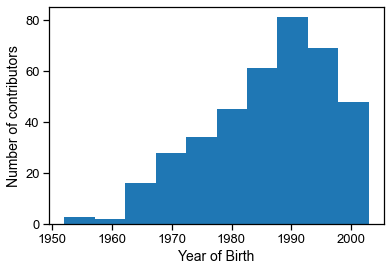

In [5]:
fig, ax = plt.subplots()
ax.hist(unique_coders.year_of_birth)
ax.set_xlabel('Year of Birth')
ax.set_ylabel('Number of contributors')
plotting_utils.export_figure('contributors_year_of_birth', figure_folder=figure_folder, png=True, svg=True)

In [6]:
# Table with all unique years of birth
year_of_birth_df = unique_coders.groupby('year_of_birth').agg({'coder_id': 'count'}).reset_index()
year_of_birth_df.rename(columns={'coder_id': 'counts'}, inplace=True)
# Export
year_of_birth_df.to_csv(outputs_folder + 'contributors_year_of_birth.csv', index=False)

In [7]:
year_of_birth_df

year_of_birth  counts
0            1952       1
1            1953       1
2            1955       1
3            1960       1
4            1962       1
5            1963       5
6            1964       4
7            1965       4
8            1966       1
9            1967       2
10           1968       2
11           1969       7
12           1970       9
13           1971       6
14           1972       4
15           1973       3
16           1974       9
17           1975      10
18           1976       5
19           1977       7
20           1978       6
21           1979      13
22           1980      10
23           1981       9
24           1982       7
25           1983       9
26           1984      18
27           1985      15
28           1986      10
29           1987       9
30           1988      14
31           1989      16
32           1990      20
33           1991      16
34           1992      15
35           1993      11
36           1994      17
37           1995      18
38           1996      10
39           1997      13
40           1998       8
41           1999       9
42           2000      11
43           2001       9
44           2002      10
45           2003       1

In [8]:
# Summarise age groups
def year_to_age_group(year_of_birth, present_year=2020):
    age = present_year - year_of_birth
    age_group = int(np.floor(age/10)*10)
    age_group = f'{str(age_group)}-{str(age_group+9)}'
    return age_group

year_of_birth_df['age'] = 2020 - year_of_birth_df.year_of_birth
year_of_birth_df['age_group'] = year_of_birth_df['year_of_birth'].apply(lambda x: year_to_age_group(x))
age_groups = year_of_birth_df.groupby('age_group').agg({'counts': 'sum'}).reset_index()
age_groups

age_group  counts
0     10-19      20
1     20-29     128
2     30-39     127
3     40-49      73
4     50-59      35
5     60-69       4

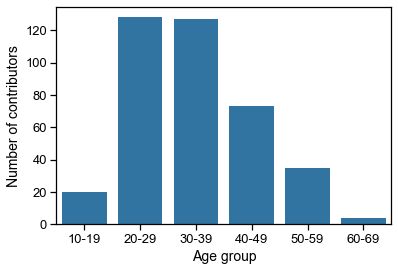

In [9]:
sns.barplot(data=age_groups, x='age_group', y='counts', color='C0')
plt.xlabel('Age group')
plt.ylabel('Number of contributors')
plotting_utils.export_figure('contributors_age_group', figure_folder=figure_folder, png=True, svg=True)

## 1.2 Location

In [10]:
# Table with all unique years of birth
df = unique_coders.groupby('nation').agg({'coder_id': 'count'}).reset_index()
df = df.rename(columns={'coder_id': 'counts'}).sort_values('counts', ascending=False)
# Export
df.to_csv(outputs_folder + 'contributors_nation.csv', index=False)
df

nation  counts
0           England     334
2          Scotland      31
3             Wales      19
1  Northern Ireland       3

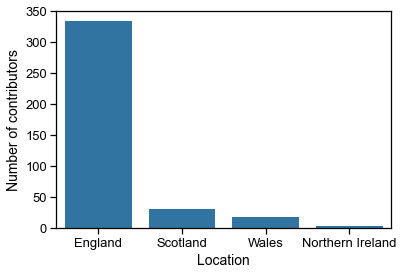

In [11]:
plt.figure(figsize=(6,4))
sns.barplot(data=df, x='nation', y='counts', color='C0')
plt.xlabel('Location')
plt.ylabel('Number of contributors')
plotting_utils.export_figure('contributors_nation', figure_folder=figure_folder, png=True, svg=True)

# 2. Remove fields and export the table

In [12]:
# Convert year of birth to age groups
batch_results_ = batch_results.copy()
batch_results_['age_group'] = batch_results_.year_of_birth.apply(lambda x: year_to_age_group(x))

# Drop the fields
batch_results_ = batch_results_.drop(['year_of_birth', 'nation'], axis=1)

# Export
batch_results_.to_csv(outputs_folder + 'crowd_feasibility_ratings.csv', index=False)

In [13]:
len(batch_results_)

70359

In [14]:
batch_results_.sample(3)

classification_id  subject_ids  origin_id             origin_label  \
26492          298061855     53141822        178  boring machine operator   
3613           295886248     53138211        732             hotel porter   
9859           291754485     52683979       1208           policy manager   

                                      origin_description  destination_id  \
26492  Boring machine operators prepare, operate, and...            1980   
3613   Hotel porters welcome guests to accommodation ...            2183   
9859    Policy managers are responsible for managing ...             261   

               destination_label  \
26492          wood pallet maker   
3613   civil enforcement officer   
9859     data warehouse designer   

                                 destination_description  \
26492  Wood pallet makers create wood pallets for use...   
3613   Civil enforcement officers patrol the streets ...   
9859   Data warehouse designers are responsible for p...   

                                perfectly_matched_skills  \
26492  monitor conveyor belt; remove processed workpi...   
3613                                                 NaN   
9859                          business process modelling   

                                partially_matched_skills  ...  \
26492                                                NaN  ...   
3613                                                 NaN  ...   
9859   manage standards for data exchange; define tec...  ...   

      familiarity_with_destination_1-5  feasibility_1-5  \
26492                                4                2   
3613                                 1                1   
9859                                 3                2   

                                                 Reasons  \
26492  **Job market** - industry of destination job i...   
3613   **Qualifications** - different qualification r...   
9859   **Qualifications** - different qualification r...   

                   coder_id questionable_respondant_flag  gender  \
26492  cda684d248927d3237dd                         True  Female   
3613   f989db16c0d3fca1f960                        False  Female   
9859   566802cf6d9c32c4b9d6                        False    Male   

                                              background  \
26492  ['Food, drink and tobacco', 'Social work', 'Ed...   
3613   ['ICT', 'Public sector and government', 'Sales...   
9859                          ['Education','Healthcare']   

      highest_qualification                 time_stamp age_group  
26492     Bachelor's degree  2020-12-30 06:26:28+00:00     40-49  
3613                   GCSE  2020-12-18 18:15:20+00:00     20-29  
9859          Master'degree                        NaN     20-29  

[3 rows x 22 columns]

In [15]:
# Drop the fields
pd.read_csv(path_to_val_data_1).drop(['year_of_birth', 'nation'],axis=1).to_csv(useful_paths.data_dir + 'raw/validation/nesta_output_16Dec.csv',index=False)
pd.read_csv(path_to_val_data_2).drop(['year_of_birth', 'nation'],axis=1).to_csv(useful_paths.data_dir + 'raw/validation/nesta_output_4_Jan_2021.csv',index=False)
